In [1]:
!jt -r

Reset css and font defaults in:
C:\Users\anoni\.jupyter\custom &
C:\Users\anoni\AppData\Roaming\jupyter\nbextensions


# Установка библиотек

In [384]:
!pip install -U scikit-learn

Установка **scikit-learn**

Библиотека для обучения модели

In [7]:
!pip install pandas

Установка **pandas**

Библиотека для чтения и обработки датасета

In [19]:
pip install langdetect

     -------------------------------------- 981.5/981.5 KB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for langdetect, since package 'wheel' is not installed.
  Running setup.py install for langdetect: started
  Running setup.py install for langdetect: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


Установка **langdetect**

Библиотека для определения основного языка текста

In [22]:
!pip install nltk

     ---------------------------------------- 1.5/1.5 MB 2.6 MB/s eta 0:00:00
  Using cached regex-2022.1.18-cp310-cp310-win_amd64.whl (273 kB)
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)


Установка **nltk**

Библиотека для удаления из текста stop слов 

In [48]:
!pip install matplotlib

  Using cached matplotlib-3.5.1-cp310-cp310-win_amd64.whl (7.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.29.1-py3-none-any.whl (895 kB)
  Using cached Pillow-9.0.1-cp310-cp310-win_amd64.whl (3.2 MB)
  Using cached kiwisolver-1.3.2-cp310-cp310-win_amd64.whl (52 kB)


Установка **matplotlib**

Библиотека для визуализации данных

In [1]:
!pip install plotly

# Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from langdetect import detect
from tqdm import tqdm
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import learning_curve
import pickle

# Первичная обработка датасета

In [2]:
data = pd.read_csv("labeled.csv")

Загрузка датасета с токсичными комментриями

In [3]:
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [4]:
data.dtypes

comment     object
toxic      float64
dtype: object

In [5]:
data.toxic = data.toxic.apply(int)

In [6]:
data.size

28824

In [7]:
data = data.drop_duplicates()

Удаления дубликатов

## Проверка на null значения

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  14412 non-null  object
 1   toxic    14412 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 337.8+ KB


## Визуализация отношения токсичных комментриев к обычным

Text(0.5, 1.0, 'Отношение комментариев')

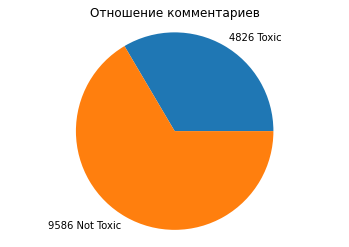

In [9]:
labels = [f"{len(data.loc[data.toxic == 1])}" + " Toxic", f"{len(data.loc[data.toxic == 0])}" + " Not Toxic"]
fig, ax = plt.subplots()
ax.pie([len(data.loc[data.toxic == 1]), len(data.loc[data.toxic == 0])], labels=labels)
ax.axis("equal")
plt.title("Отношение комментариев")

Круговая диаграмма отношения

# Финальная обработка данных

## Первичная обработка текста

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anoni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Загрузка stopwords

In [11]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

In [12]:
def tokinize_sentence(sentence: str):
    sentence = sentence.strip().lower()
    if detect(sentence) == "ru":
        sentence.replace("e", "е").replace("a", "а").replace("c", "с").replace("p", "р").replace("o", "о").replace("M", "м").replace("H", "н").replace("B", "в")
        sentence.replace("не ", "не").replace("no ", "no")
    for i in string.punctuation:
        if i in sentence and i != " ":
            sentence = sentence.replace(i, '')
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return " ".join(tokens)

Функция для обработки текста 

In [13]:
tqdm.pandas()

data_token = data.copy()
data_token.comment = data_token.comment.progress_apply(tokinize_sentence)
data_token.head()

100%|███████████████████████████████████████████████████████████████████████████| 14412/14412 [00:54<00:00, 265.88it/s]


,comment,toxic
0,верблюдовт дебил бл,1
1,хохл эт отдушин затюкан россиянин мол вон хохл...,1
2,собак собач смерт,1
3,страниц обнов деб эт оскорблен доказа факт нед...,1
4,убед 6страничн пдф скрипал отрав росс анализир...,1


Обработка датасета для дальнейшего обучения

## Удаление дубликатов и пустых значений

### Поиск и удаление пустых значений

In [14]:
data = data_token.copy()
empty = data[data.comment == '']
print('Количество пустых значений: ', len(empty))
data = data.drop(empty.index)

Количество пустых значений:  1


### Поиск дубликатов

In [15]:
print('Дубликаты: ', data.duplicated().sum())

Дубликаты:  222


### Удаление дубликатов

In [16]:
data = data.drop_duplicates()

Первичное удаление дубликатов

In [17]:
data.head()

,comment,toxic
0,верблюдовт дебил бл,1
1,хохл эт отдушин затюкан россиянин мол вон хохл...,1
2,собак собач смерт,1
3,страниц обнов деб эт оскорблен доказа факт нед...,1
4,убед 6страничн пдф скрипал отрав росс анализир...,1


In [18]:
comment_duplicated = data[data.comment.duplicated('last')]
comment_duplicated.head()

,comment,toxic
127,ночн большевистск обострен,1
158,эт сво мам сестр родн утр,1
358,писечк поперек эт мам переда,1
540,прост социальн несправедлив дает поко предыдущ...,0
660,осторожн увид пишет переебет ног,1


Вывод дубликатов

In [19]:
data = data.drop_duplicates(subset='comment')

Удаление дубликатов по столбцу comment

# Визуализация самых популярных слов

In [20]:
sorted_counter = Counter(' '.join(data.comment.values).split()).most_common()
sorted_counter[:5]

[('эт', 4405), ('так', 1550), ('котор', 1386), ('прост', 1176), ('сво', 954)]

Самые популярные слова

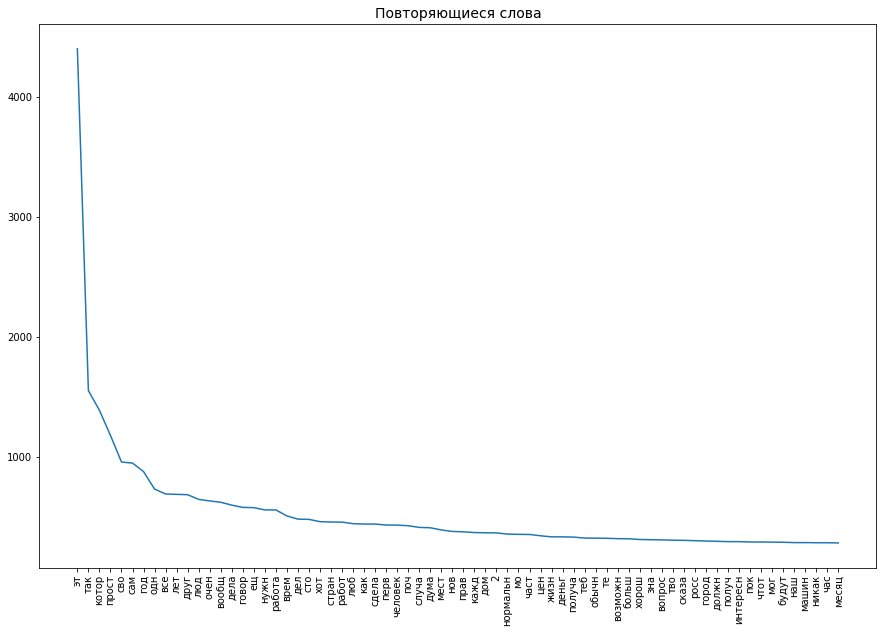

In [21]:
plt.figure(figsize=(15, 10))
plt.plot([i[0] for i in sorted_counter][:70], [i[1] for i in sorted_counter][:70])
plt.xticks(rotation=90)
plt.title('Повторяющиеся слова', fontsize=14)
plt.show()

Визуализация самых популярных слов

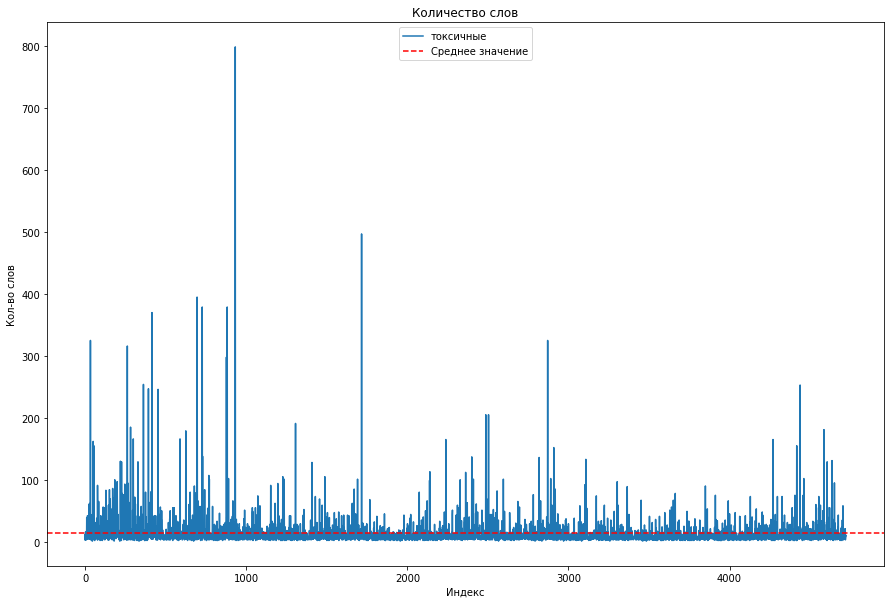

In [22]:
plt.figure(figsize=(15, 10))
plt.plot([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]], label="токсичные")
plt.xlabel("Индекс")
plt.ylabel("Кол-во слов")
plt.title("Количество слов")
plt.axhline(pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]]).mean()[0], linestyle="dashed", label="Среднее значение", c="r")
plt.legend(loc=9)
plt.show()

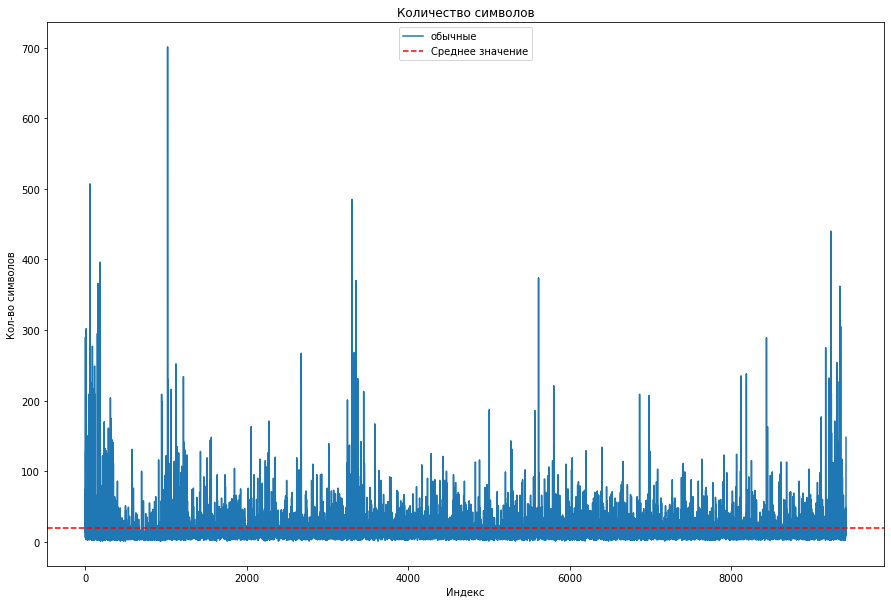

In [23]:
plt.figure(figsize=(15, 10))
plt.plot([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]], label="обычные")
plt.xlabel("Индекс")
plt.ylabel("Кол-во символов")
plt.title("Количество символов")
plt.axhline(pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]]).mean()[0], linestyle="dashed", label="Среднее значение", c="r")
plt.legend(loc=9)
plt.show()

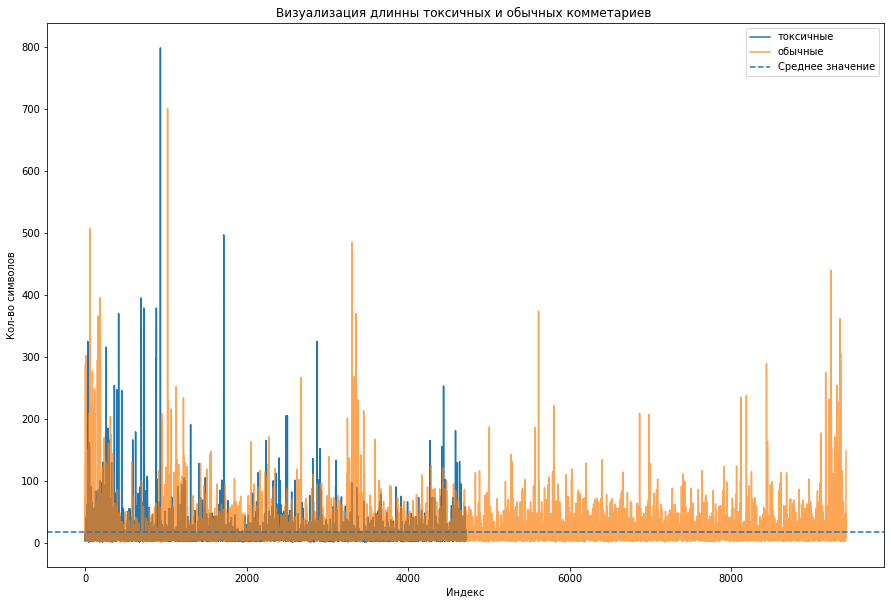

In [24]:
plt.figure(figsize=(15, 10))
plt.plot([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]], label="токсичные")
plt.plot([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]], alpha=0.7, label="обычные")
plt.xlabel("Индекс")
plt.ylabel("Кол-во символов")
plt.title("Визуализация длинны токсичных и обычных комметариев ")
plt.axhline(pd.DataFrame([len(i.split()) for i in data["comment"]]).mean()[0], linestyle="dashed", label="Среднее значение")
plt.legend(loc=1)
plt.show()

Text(0.5, 1.0, 'Визуализация начиная с самых длинных предложений')

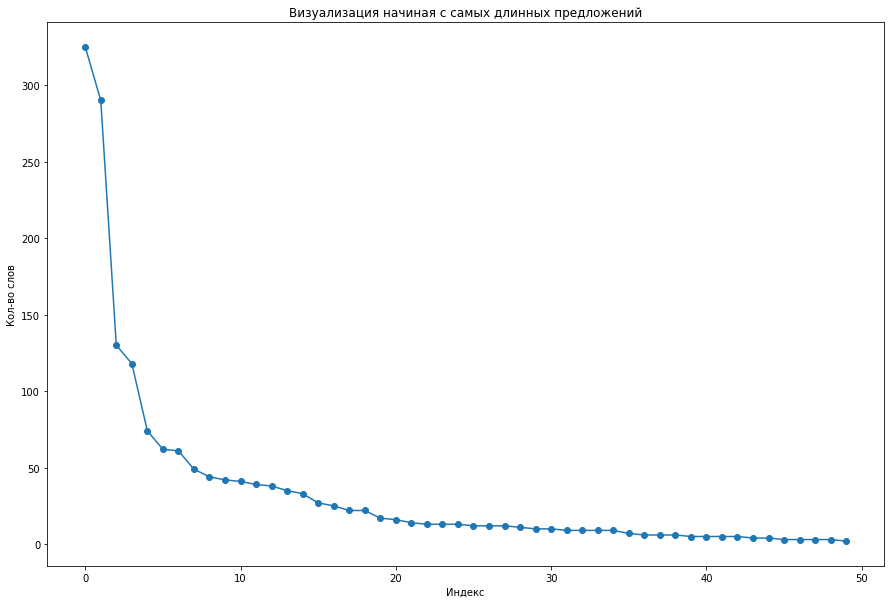

In [25]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]], reverse=True), marker="o")
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных предложений")

Text(0.5, 1.0, 'Визуализация начиная с самых коротких предложений')

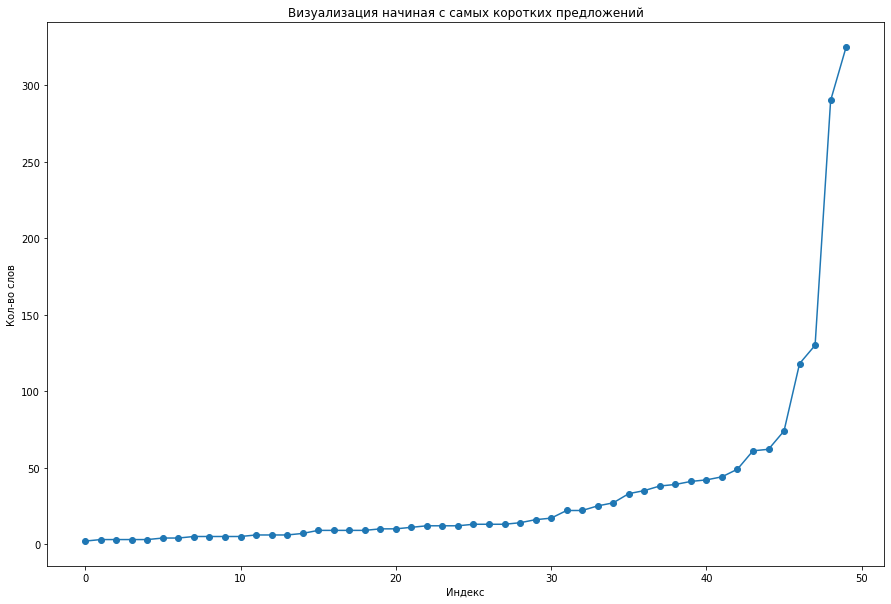

In [26]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]]), marker="o")
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых коротких предложений")

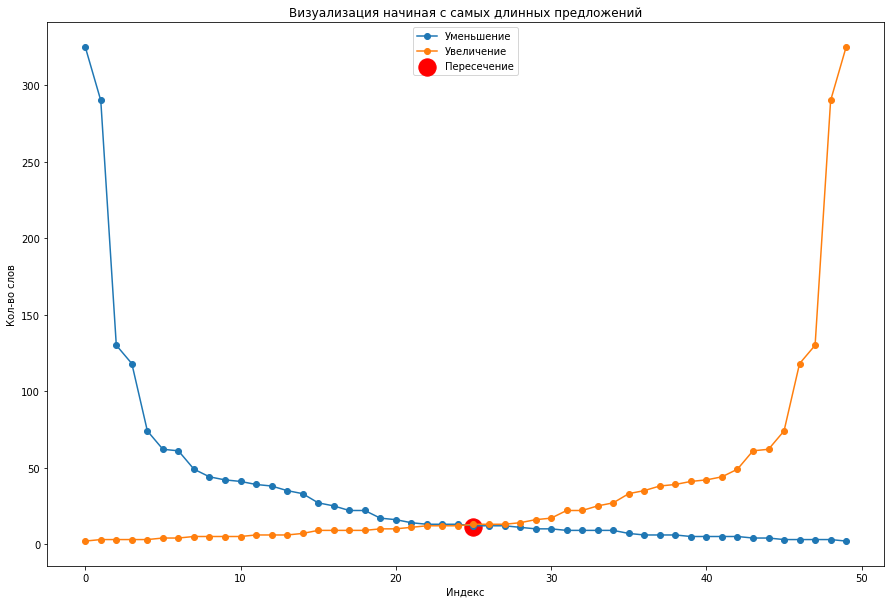

In [27]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]], reverse=True), marker="o", label="Уменьшение")
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]]), marker="o", label="Увеличение")
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных предложений")
plt.scatter(25, 11, c = 'red', s=300, label="Пересечение")
plt.legend(loc=9)

In [28]:
print("Среднее кол-во слов:", pd.DataFrame([len(i.split()) for i in data["comment"]]).mean()[0])
print("Среднее кол-во слов токсичных комментариев:", pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]]).mean()[0])
print("Среднее кол-во слов обычных комментариев:", pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]]).mean()[0])

Среднее кол-во слов: 17.296762335642583
Среднее кол-во слов токсичных комментариев: 14.022650296359018
Среднее кол-во слов обычных комментариев: 18.938335809806834


Text(0.5, 1.0, 'Визуализация начиная с самых длинных предложений')

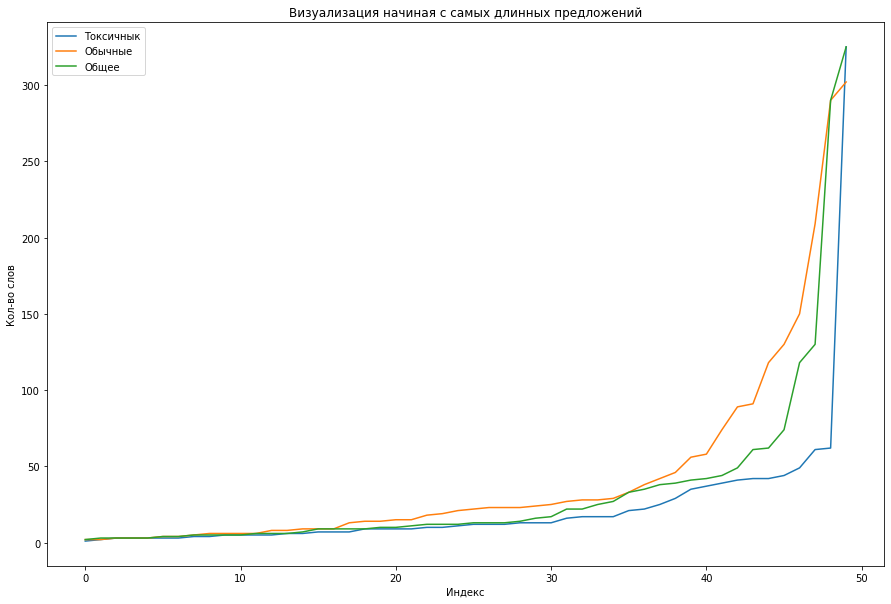

In [29]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]][:50]), label="Токсичнык")
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]][:50]), label="Обычные")
plt.plot(sorted([len(i.split()) for i in data["comment"]][:50]), label="Общее")
plt.legend(loc=2)
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных предложений")

Text(0.5, 1.0, 'Визуализация начиная с самых длинных предложений')

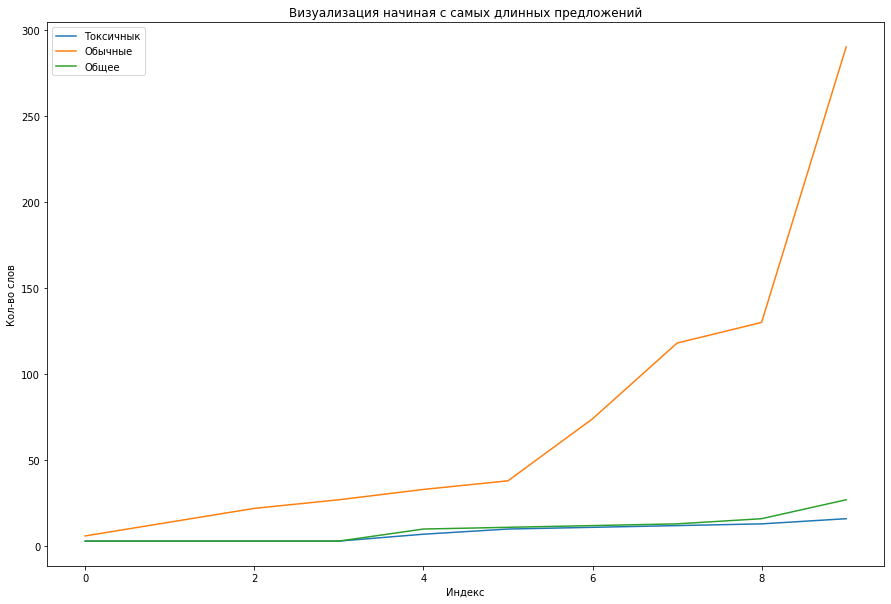

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]][:10]), label="Токсичнык")
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]][:10]), label="Обычные")
plt.plot(sorted([len(i.split()) for i in data["comment"]][:10]), label="Общее")
plt.legend(loc=2)
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных предложений")

# Разделение данных на тренировочную и тестовую выборку, создание фич

## Разделение на тренировочную и тестовую выборку

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data["comment"], data["toxic"], test_size=0.20, random_state=311)

## Создание фичей

In [32]:
vectorizer = TfidfVectorizer(ngram_range=(2,4), analyzer='char_wb', max_df=0.8, min_df=10)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print('Фичи: ', len(vectorizer.get_feature_names()))

Фичи:  16407


C:\Users\anoni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Создание фичей для обучения

# Обучение модели

## Создание и обучение модели

In [33]:
model = LogisticRegression(max_iter=10000, C=3, solver='liblinear')

Создание модели для обучения

In [34]:
model.fit(X_train, y_train)

LogisticRegression(C=3, max_iter=10000, solver='liblinear')

обучение модели

### Предсказание целевой переменной на тестовых данных

In [35]:
y_pred = model.predict(X_test)

Создание предсказаний

## Проверка score

### Вывод основных метрик

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1936
           1       0.88      0.79      0.83       894

    accuracy                           0.90      2830
   macro avg       0.89      0.87      0.88      2830
weighted avg       0.90      0.90      0.90      2830



Визуализация точности предсказаний

## Визуализация предсказаний

### Визуализация предсказаний тестовых данных

C:\Users\anoni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


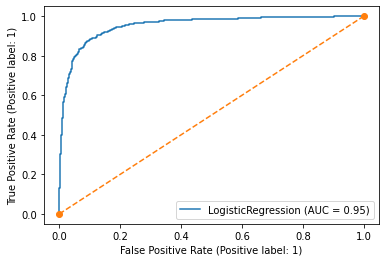

In [37]:
plot_roc_curve(model, X_test, y_test)
plt.plot([0, 1], [0, 1],'o--')
plt.show()

### Визуализация предсказаний тренировочных данных данных

C:\Users\anoni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


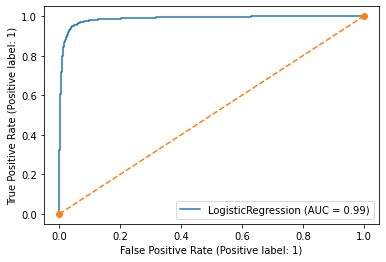

In [38]:
plot_roc_curve(model, X_train, y_train)
plt.plot([0, 1], [0, 1],'o--')
plt.show()

### Визуализация модели

C:\Users\anoni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


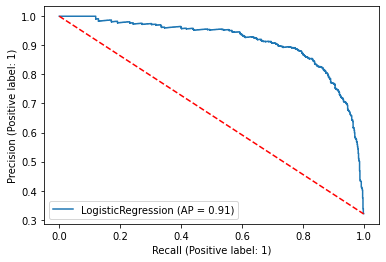

In [39]:
plot_precision_recall_curve(estimator=model, X=X_test, y=y_test)
plt.plot([0, 1], [1, 0.32],'r--')
plt.show()

In [40]:
train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(), X_train, y_train, train_sizes=[0.001, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9], cv=5)

Text(0, 0.5, 'y')

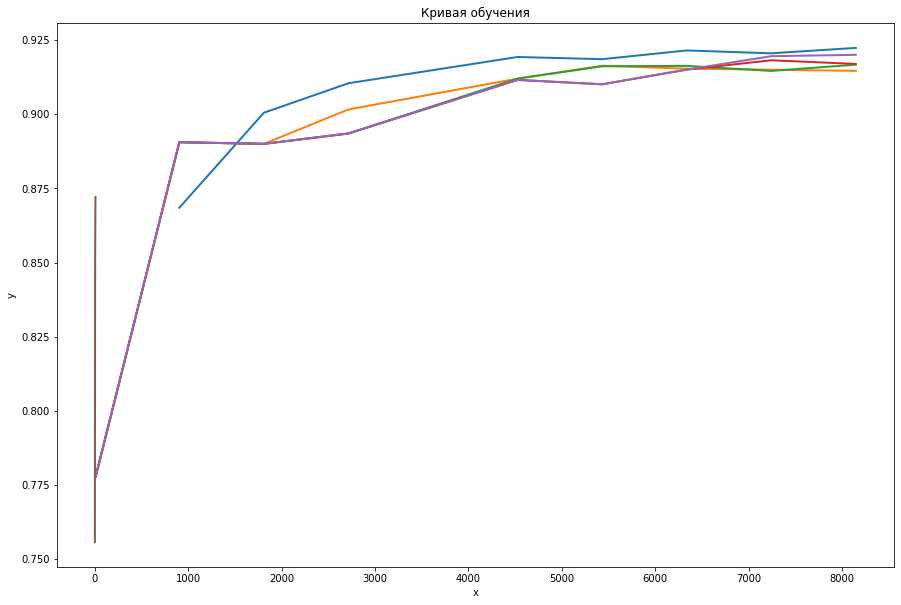

In [41]:
plt.figure(figsize=(15, 10))
plt.plot(train_sizes, train_scores,valid_scores.mean(axis=1), lw=2,
         label='cross-validation')
plt.title('Кривая обучения')
plt.xlabel('x')
plt.ylabel('y')

# Тест и сохраниение модели

## Тестирование модели

In [54]:
toxic_propabality = model.predict_proba(vectorizer.transform([tokinize_sentence("антон гандон")]))[0, 1]
print(f'Probability of toxicity: {toxic_propabality:.2f}')

Probability of toxicity: 0.60


Тест модели

## Сохраниение модели

In [43]:
with open("model.bf", "+wb") as file:
    pickle.dump(model, file)

Сохранение модели